In [1]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
import pyklip.fakes as fakes
from astropy.modeling import models, fitting
import math
import lmfit
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
#gaussian model generator for FM planet PSF
def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def fitPrimary(x0, y0, im, radius=10, xIndex=None, yIndex=None,
               weight=None, mask=None,
               returnModel=False):
    """
    fit a 2d gaussian to the region of interest and return the fitted x and y
    """
    if xIndex is None:
        xIndex = np.arange(im.shape[1]).astype(int)
    if yIndex is None:
        yIndex = np.arange(im.shape[0]).astype(int)

    subXIndex, = np.where(np.abs(xIndex - x0) < radius)
    subYIndex, = np.where(np.abs(yIndex - y0) < radius)

    yyIndex, xxIndex = np.meshgrid(subYIndex, subXIndex,
                                   indexing='ij')
    yy, xx = np.meshgrid(yIndex[subYIndex], xIndex[subXIndex],
                         indexing='ij')

    subim = im[yyIndex.astype(int), xxIndex.astype(int)]

    if weight is None:
        subweight = np.ones_like(subim)
    else:
        subweight = weight[subYIndex, subXIndex]

    if mask is None:
        mask = np.zeros_like(subim)
    else:
        # if there are masked pixel, set the corresponding pixels' weight to 0
        weight[np.where(mask) != 0] = 0
    p = Parameters()
    p.add('g_centerx', value=x0)
    p.add('g_centery', value=y0)
    p.add('g_amplitude', value=np.nanmax(subim))
    p.add('g_sigmax', value=1, min=0)
    p.add('g_sigmay', value=1, min=0)
    p.add('c_c', value = 0)
    pFit = gModel.fit(subim, params=p, x=xx, y=yy, weights=subweight,
                      verbose=True,
                      method='powell',
                      nan_policy='omit')
    modelImage = np.zeros_like(im) 
    modelImage[yyIndex.astype(int), xxIndex.astype(int)] = pFit.best_fit.reshape(yy.shape) 

    print(pFit.fit_report())
    return pFit, modelImage

0.6931471805599453
746.7336241487463
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CAL_ARCH= '67070511810774'     / Archon time in 10ns per tick at CAL_SYS        CAL_SYS = '2023-12-07T01:53:58.129515' / system time at CAL_ARCH                CAMD_VER= 'Nov 26 2023 20:21:34' / camerad build date                           COADDS  =                    3 / number of coadds                               FIL

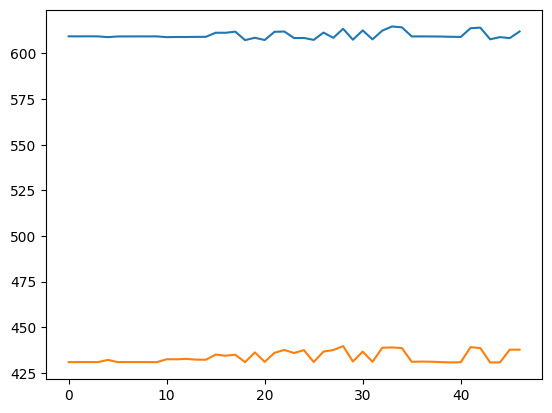

In [3]:
#returns median of aligned images to use as PSF
def ADI_psfs(psflist): 
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            
    medpsfs = np.nanmedian(alignedpsfs, axis=0)

    
    return np.array([medpsfs])

    



#returns fits-processed images, centers, and parallactic angles for every file in the list with given dimensions
def ADI_getImages(flist, xdim, ydim):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    
    boxrad = 4
    cx, cy = 611, 436
    b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    threshold = 5.5
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)

        if i == 0:
            print(head)
        print(head['ITIME'])
        print(head['COADDS'])
        #find centers
        
        ctrs[i] = (l, b) + centroid_2dg(rawcube[i,b:t,l:r])
        
        if ctrs[i][0] > r or ctrs[i][0] < l or ctrs[i][1] > t or ctrs[i][1] < b:
            shift, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:], upsample_factor=100, normalization=None)
            ctrs[i] = ctrs[0] - shift

        # if i > 0:
        #     movement = abs(ctrs[i][1] - ctrs[i-1][1]) + abs(ctrs[i][0] - ctrs[i-1][0])
        #     if i != 10 and movement > threshold:
        #         print(i, movement)
        #         ctrs[i] = ctrs[i - 1]
        # if i == 0:
        #     print(b, t, l, r)
        #     ctrs[i] = (l, b) + centroid_2dg(rawcube[0,b:t,l:r])
            
                                                    #12_Kshort: (618, 431)
                                                    #02_H: (615, 433)
                                                    #12_CH4short: (599, 454)
            
        # else:
        #     shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
        #                                             upsample_factor=100,
        #                                             normalization=None)
        #     ctrs[i] = ctrs[0] - shifts
            
        parangs[i] = head['PARANG']

    # ydat, xdat = np.indices(rawcube[0].shape)
    # for i in range(len(flist)):
    #     rawTemp = np.copy(rawcube[i])
    #     cx, cy = ctrs[i]

    #     rawTemp[int(cy),int(cx)] = np.nan
    #     fits.writeto(f'../rawPlusCenters/2023_12_J/new{i}.fits', rawTemp, overwrite=True)
        
    #     rawTemp[b,l:r], rawTemp[t,l:r], rawTemp[b:t, l], rawTemp[b:t, r] = np.nan, np.nan, np.nan, np.nan
    #     distance_from_center = np.sqrt((xdat - cx)**2 + (ydat-cy)**2)
    #     rawTemp[np.where(distance_from_center <= 3)] = np.nan
    #     fits.writeto(f'../rawPlusCenters/2023_12_J/n{i}.fits', rawTemp, overwrite=True)
    
    # distance_from_center = np.sqrt((xdat - ctrs[0][0])**2 + (ydat-ctrs[0][1])**2)
    # medcube = np.nanmedian(rawcube, axis=0)
    # newMedCube = np.copy(medcube)
    # newMedCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('medIMG.fits', newMedCube, overwrite=True)
    
    # tempCube = np.copy(rawcube[0,:,:])
    # tempCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('rawIMG.fits', tempCube, overwrite=True)

    # cx, cy = int(ctrs[0][0]), int(ctrs[0][1])
    # b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    # print(cx, cy, b, t, l, r)
    # centroid = centroid_2dg(medcube[b:t, l:r])
    # print(centroid)
    # distance_from_center_2 = np.sqrt((xdat - l - centroid[0])**2 + (ydat - b - centroid[1])**2)
    # tempCube2 = np.copy(medcube)
    # tempCube2[np.where(distance_from_center_2 <= 3)] = np.nan
    # tempCube2[b,l:r], tempCube2[t,l:r], tempCube2[b:t, l], tempCube2[b:t, r] = np.nan, np.nan, np.nan, np.nan
    # fits.writeto('centroidIMG.fits', tempCube2, overwrite=True)
    
    plt.plot(ctrs)
    return rawcube, ctrs, parangs
        
    
#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)

    fits.writeto('tempstar.fits',aligned_cube[1,:,:],overwrite=True)
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]


#ADI
def ADI_NIRC2(flist):
    rawcube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_02_H',
                                        annuli=9,subsections=4,numbasis=[1,7,15,30],maxnumbasis=150,mode="ADI",
                                        movement=1)

    return sub_imgs, ctrs[0]


#fake planet injection for contrast calibration
def injectFakePlanets(flist, stellar_flux):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6  , parangs=parangs)
    
    input_planet_fluxes = [1e-6, 2e-7, 4e-8, 8e-9]
    seps = [100, 200, 300, 400]
    fwhm = 2.5

    for input_planet_flux, sep in zip(input_planet_fluxes, seps):
        injected_flux = input_planet_flux * stellar_flux
        for pa in [0, 90, 180, 270]:
            fakes.inject_planet(dataset.input, dataset.centers, injected_flux, dataset.wcs, sep, pa, fwhm=fwhm)

    parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_12_CH4short', fileprefix='fakes',
                              annuli=9, subsections=4, numbasis=[1,20,50,100], calibrate_flux=True,
                              mode='ADI')
    return input_planet_fluxes, seps, dataset.wcs

#Forward-Modeling
def forwardmodel(flist, psflist=None, gaussian=None, fwhm=3):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)

    print(ctrs[0])
    
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 191
    # guesspa = 7.8
    guesspa = 7.3        #for 2023_02_H
    guessflux = 1.0

    if len(gaussian) > 0:
        print('Gaussian')
        fm_psf_stamp = gaussian
        fits.writeto('gaussian_model.fits', fm_psf_stamp, overwrite=True)
    elif len(psflist) > 0:
        print('PSF')
        instrument_psfs = ADI_psfs(psflist)
        fm_psf_stamp = instrument_psfs[0, 691:711, 477:497]
        fits.writeto('psf_stamp.fits', fm_psf_stamp, overwrite=True)
    else:
        return

    print(datacube.shape)
    print(fm_psf_stamp.shape)
    fm_psf_stamp = fm_psf_stamp.reshape(1, fm_psf_stamp.shape[0], fm_psf_stamp.shape[1])

    fm_class = fmpsf.FMPlanetPSF(fm_psf_stamp.shape, numbasis, guesssep, guesspa, guessflux, fm_psf_stamp,
                             input_wvs = np.unique(dataset.wvs), flux_conversion = [1]*datacube.shape[0])

    outputdir = f"../fmdata/FM_2023_{band}"

    """   ___CHANGE THIS___   """
    
    prefix = f'fwhm={fwhm}'
    annulus_bounds = [[guesssep-15, guesssep+15]] 
    subsections = 1 
    padding = 0
    movement = 4

    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=3, subsections=subsections, padding=padding, movement=movement)
    
#   ___CHANGE THIS___   """

band = '12_Kshort'
datadir = f'../rawdata/2023_{band}/'
flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)
#psflist = sorted(glob.glob(psfdir + '*.fits'))

conv = 2*math.sqrt(2*math.log(2))
print(math.log(2))

fwhms = {
    '02_H': 2.03060614 * conv,
    '12_Kshort': 1.990643135 * conv,
    '12_CH4short': 1.557713995 * conv,
    '12_J': 2.06846173 * conv
}

gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
print(gaussian_base_signal)
forwardmodel(flist, gaussian=gaussian, fwhm=fwhms[band])

# for val in fwhm:
#     gaussian = makeGaussian(size=120, amplitude=30, fwhm=val)
#     #fits.writeto('gaussian_psf.fits', gaussian, overwrite=True)
#     gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
#     forwardmodel(flist, gaussian=gaussian, fwhm=val)


#ADI_getImages(flist, 1024, 1024)
    #2023_12_H a=30 fwhm=5
    #2023_12_J a=60 fwhm=4
    #2023_12_CH4short a=60 fwhm=4
    #2023_12_Kshort a=25 fwhm=5
    #2023_02_H a=125 fwhm=4

#flist_adi, cen = ADI_NIRC2(flist)
#diskForwardmodel(flist, psflist)
#forwardmodel(flist, psflist)
#ADI_getImages(flist, 1024, 1024)
#ADI_NIRC2(flist)
#cADI_NIRC2(flist)
# forwardmodel(flist, gaussian=gaussian)
#flist_adi, cen = ADI_NIRC2(flist)
#input_planet_fluxes, seps, wcs = injectFakePlanets(flist, 179300000)

#2d plot centers

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
Raw X/Y Centroid = (25.752737601085414, 189.71749146520693) with statistical error of [-0.01224881  0.02658581] pix in X and [-0.13898311  0.14024169] pix in Y
Raw Sep/PA Centroid = (191.45647174852866, 7.729175125941388) with statistical error of [ 0.13917602 -0.13755262] pix in Sep and [ 0.00716747 -0.0091101 ] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 191.45647174852866 +/- 0.14712158417626703 ([0.14788497 0.1463582 ]) pix, PA = 7.729175125941388 +/- 0.13111474021209021 ([0.13105445 0.13117503]) degrees
Sep = 1.9090124798045793 +/- 0.001654823855637629 ([0.00166157 0.00164808]) mas, PA = 7.729175125941388 +/- 0.13111474021209021 ([0.13105445 0.13117503]) degrees
RA offset = 25.75273760108542 +/- 0.43384341724008435 ([0.43352258 0.43416425]) pix
Dec offset = 189.71749146

<Figure size 1000x800 with 0 Axes>

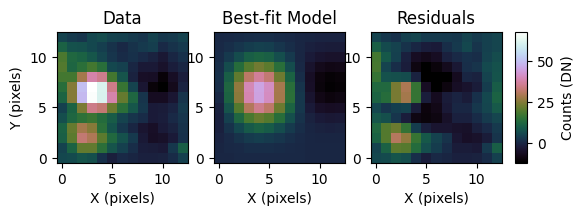

In [7]:
def processFMObject(output_prefix):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")
    
    # get FM frame
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']
    
    # get data_stamp frame
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]
    
    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']

    fit = fitpsf.FMAstrometry(guesssep, guesspa, 13, method="mcmc")
    fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)
    fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
    corr_len_guess = 3.
    corr_len_label = r"$l$"
    fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
    # set bounds
    x_range = 1.5 # pixels
    y_range = 1.5 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    
    # run MCMC fit
    fit.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=1)
    fig = pylab.figure(figsize=(10,8))
    
    # # grab the chains from the sampler
    # chain = fit.sampler.chain
    
    # # plot RA offset
    # ax1 = fig.add_subplot(411)
    # ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)

    # ax1.set_xlabel("Steps")
    # ax1.set_ylabel(r"$\Delta$ RA")
    
    # # plot Dec offset
    # ax2 = fig.add_subplot(412)
    # ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
    # ax2.set_xlabel("Steps")
    # ax2.set_ylabel(r"$\Delta$ Dec")
    
    # # plot flux scaling
    # ax3 = fig.add_subplot(413)
    # ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
    # ax3.set_xlabel("Steps")
    # ax3.set_ylabel(r"$\alpha$")
    
    # # plot hyperparameters.. we only have one for this example: the correlation length
    # ax4 = fig.add_subplot(414)
    # ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
    # ax4.set_xlabel("Steps")
    # ax4.set_ylabel(r"$l$")

    # fig = pylab.figure()
    # fig = fit.make_corner_plot(fig=fig)

    fig = pylab.figure()
    fig = fit.best_fit_and_residuals(fig=fig)

    # print(fig)

    # # get residuals
    # print(fit.fit_flux.bestfit)
    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(fit.data_stamp_x_center, fit.data_stamp_y_center)
    # print(fit.fm_stamp)

    # dx, dy = fit.fit_x.bestfit - fit.data_stamp_x_center, fit.fit_y.bestfit - fit.data_stamp_y_center
    # fm_bestfit = fit.fit_flux.bestfit * sinterp.shift(fit.fm_stamp, [dy, dx])

    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(dx, dy)
    # img = fit.data_stamp - fm_bestfit[5:-5, 5:-5]#float(fm_bestfit[5:-5, 5:-5])
    # stampcx, stampcy = fit.fit_x.bestfit - 5, fit.fit_y.bestfit - 5
    # central_residuals = np.matrix(img[2:-4, 2:-4]).astype(np.float32)
    # central_residuals = central_residuals ** 2
    # fits.writeto('bestfit.fits', np.matrix(fm_bestfit[5:-5, 5:-5]).astype(np.float32), overwrite=True)
    # fits.writeto('residual_test.fits', central_residuals, overwrite=True)
    # print(np.matrix.sum(np.matrix(img[]).astype(np.float32)))
    # fits.writeto('residual_test.fits', img, overwrite=True) 
    
    fit.propogate_errs(star_center_err=0.05, platescale=.009971, platescale_err=0.000004, pa_offset=0.0, pa_uncertainty=0.13)

    # print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fit.raw_RA_offset.bestfit, fit.raw_RA_offset.error,
    #                                                                                     fit.raw_Dec_offset.bestfit, fit.raw_Dec_offset.error))
    
    # # Full error budget included
    # print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.RA_offset.bestfit, fit.RA_offset.error))
    # print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.Dec_offset.bestfit, fit.Dec_offset.error))
    
    # # Propogate errors into separation and PA space
    # print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fit.sep.bestfit, fit.sep.error))
    # print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fit.PA.bestfit, fit.PA.error))

    # # Propagate errors into flux/alpha
    print("Planet flux scaler value (alpha) is at {0} with a 1-sigma uncertainty of {1}".format(fit.fit_flux.bestfit, fit.fit_flux.error))
    # np.matrix.sum(np.matrix(fm_bestfit).astype(np.float32)),, np.matrix.sum(central_residuals.astype(np.float32))
    return fit.fit_flux.bestfit

def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
"""   ___CHANGE THIS___   """

alpha_flux = processFMObject('../fmdata/FM_2023_12_J/fwhm=f2')
# print(alpha_flux * gaussian_base_signal)

# x = [4, 5, 5.5, 6, 7]
# residual_fluxes = []
# fluxes = []
# alphas = []
# for band in ['12_H', '12_J', '02_H']:
#     for i in x:
#         print('fwhm =', i)
#         psf_flux = np.matrix.sum(np.matrix(makeGaussian(size=120, amplitude=30, fwhm=i)))
#         alpha_flux, total_flux, residuals = processFMObject(output_prefix + f'{band}/fwhm={i}')
#         residual_fluxes.append(residuals)
#         fluxes.append(total_flux)
#         alpha = alpha_flux * psf_flux
#         alphas.append(alpha_flux)
#         print(total_flux, alpha_flux * psf_flux)   # (!) which of these values is right? does it make a difference?

In [9]:
#calculate contrast

from scipy.ndimage import shift

star_itime = {
    '02_H': 0.014,
    '12_Kshort': 0.01,
    '12_CH4short': 0.01,
    '12_J': 0.01
}

#take in star data
def starData(band):
    
    star_path = f'../stardata/2023_{band}/*.fits'
    flist = sorted(glob.glob(star_path))
    
    # 20x20 slice containing brightest features of the star
    # aligned via centroid_2dg and shifting, then taking the sum of the median
    n = len(flist)
    rawcube = np.zeros((n, 15, 15))
    alignedcube = np.zeros((n, 13, 13))
    ctrs = []

    print(f'\n{band}')
    # print(fits.getheader(flist[0]))
    
    for i in range(n):
        # print(fits.getheader(flist[i])['ITIME'], fits.getheader(flist[i])['COADDS'])
        rawcube[i,:,:] = fits.getdata(flist[i])[50:65,25:40]
        if band == '12_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[55:70,22:37]
        if band == '02_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[122:137, 88:103]
        if band == '12_Kshort':
            if i >= 20:
                rawcube[i,:,:] = fits.getdata(flist[i])[39:54,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[51:66,27:42]
        if band == '12_CH4short':
            if i >= 10:
                rawcube[i,:,:] = fits.getdata(flist[i])[54:69,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[59:74,10:25]

        # ctrs.append((5, 5) + centroid_2dg(rawcube[i,5:10,5:10]))
        new_center = list(np.unravel_index(np.argmax(rawcube[i], axis=None), (15, 15)))
        ctrs.append(new_center)
        
        alignedcube[i,:,:] = shift(rawcube[i,:,:],shift=[7 - ctrs[i][0], 7 - ctrs[i][1]],mode='grid-constant')[1:-1,1:-1]
    
    peaks = [np.matrix.sum(np.matrix(alignedcube[i,:,:]))/(100*star_itime[band]) for i in range(len(alignedcube))]
    stddev = np.std(peaks)
    
    medcube = np.nanmedian(alignedcube, axis=0)

    
    print(band, np.matrix.sum(np.matrix(medcube))/(100*star_itime[band]), stddev)

    # check and save centers
    ydat, xdat = np.indices(rawcube[0].shape)
    for i in range(n):
        rawTemp = np.copy(alignedcube[i])
        
        
        cx, cy = ctrs[i]
        rawTemp[6,6] = 0
        
        # distance_from_center = np.sqrt((xdat - cx)**2 + (ydat-cy)**2)
        # rawTemp[np.where(distance_from_center <= 2)] = np.nan
        fits.writeto(f'../alignment/2023_{band}/n{i}.fits', rawTemp, overwrite=True)
        
    # print(medcube[0][0])
    # print(medcube.shape)
    # print(max(medcube))
    fits.writeto(f'medstar-{band}.fits', medcube, overwrite=True)
    # lmFitGaussian(medcube)
    return np.sum(medcube), medcube


def contrast(band):

    # band: [flux scaler, flux scaler error]
    alphas = {
        '12_H': [2.141395, 0.0725038],
        '12_J': [1.5594737627306137, 0.11328200854935211],
        '12_Kshort': [0.9666688488750069, 0.07761745210351367],
        '02_H': [18.620186920474172, 0.9926960599857964],
        '12_CH4short': [2.3976276410976567, 0.0917806142313633]
    }

    # band : truitime * num_coadds
    time = {
        '12_H': 7.9965 * 4,
        '12_J': 9.99671 * 3,
        '12_Kshort': 9.99671 * 3,
        '02_H': 10 * 3,
        '12_CH4short': 10 * 3
    }

    # star and planet fluxes in counts
    _, star_img = starData(band)
    pFit, best_im = fitPrimary(6, 6, star_img, radius=7, returnModel=True)
    star_counts = np.sum(best_im)
    planet_counts = alphas[band][0] * gaussian_base_signal

    # convert to fluxes by dividing by sampling rate
    planet_flux = planet_counts / time[band]
    # star_flux = star_counts / (100 * 0.0100113)
    star_flux = star_counts / (100 * star_itime[band])

    print('\nPre Conversion:')
    print(star_counts, planet_counts)

    print('\nPost Conversion:')
    print(star_flux, planet_flux)
    
    contrast = planet_flux / star_flux
    contrast_mag = math.log(contrast, 10) * -2.51

    return contrast, contrast_mag




import numpy as np
from lmfit import Model, Parameters
from lmfit.models import Gaussian2dModel, ConstantModel
from astropy.io import fits


gModel = Gaussian2dModel(prefix='g_') + ConstantModel(prefix='c_')


#map bands to apparent magnitude of HD47127
appmag = {
    '12_H': 5.277,
    '12_J': 5.561,
    '12_Kshort': 5.174,
    '02_H': 5.277,
    '12_CH4short': 5.383
}

distance = 26.6

conv = 2*math.sqrt(2*math.log(2))
print(math.log(2))

fwhms = {
    '02_H': 2.03060614 * conv,
    '12_Kshort': 1.990643135 * conv,
    '12_CH4short': 1.557713995 * conv,
    '12_J': 2.06846173 * conv
}

for band in fwhms:

    gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
    gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
    contrast_ratio, contrast_mag = contrast(band)
    
    apparent_magnitude = contrast_mag + appmag[band]
    absolute_magnitude = apparent_magnitude - 5 * math.log(distance, 10) + 5
    print(f'\nContrast magnitude, absolute magnitude for {band}')
    print(contrast_mag, absolute_magnitude)

# fitPrimary(7, 7, starData(band)[1], radius=8, returnModel=True)




#4 coadds for H coronagraph data
#9.99671 for J/Ks/CH4s, 7.9965 for H, should be less for CH4l
#true integration time of 0.0100113 sec and 100 coadds is standard across all non-coronagraphic images
##species fit -> Teff, Lbol
##template from astrophysical journal -> write stuff
##med combined star center -- 2x4 plot

#02_H klip reduction + alignment check
#orbit fit overleaf

#center first get images plotted with overlayed center coord

0.6931471805599453

02_H
02_H 91669145.58035715 10760613.069869723
[[Model]]
    (Model(gaussian2d, prefix='g_') + Model(constant, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 321
    # data points      = 169
    # variables        = 6
    chi-square         = 2.5083e+12
    reduced chi-square = 1.5389e+10
    Akaike info crit   = 3970.10558
    Bayesian info crit = 3988.88498
    R-squared          = 0.95607625
[[Variables]]
    g_centerx:    5.87638772 +/- 0.03650908 (0.62%) (init = 6)
    g_centery:    6.06592424 +/- 0.04471124 (0.74%) (init = 6)
    g_amplitude:  63313699.9 +/- 1296.47710 (0.00%) (init = 2945536)
    g_sigmax:     1.82896823 +/- 0.03224304 (1.76%) (init = 1)
    g_sigmay:     2.23224405 +/- 0.03991784 (1.79%) (init = 1)
    c_c:          386133.489 +/- 1296.48087 (0.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_amplitude, c_c)     = +0.5000
    C(g_sigmax, g_sigmay)   = -0.3426
    C(g_ce

In [53]:
def compareImgs(img1_prefix, img2_prefix):
    img1 = fits.open(img1_prefix + '-KLmodes-all.fits')[0].data[3]
    img2 = fits.open(img2_prefix + '-KLmodes-all.fits')[0].data[3]

    combinedTemp = img1 + img2
    fits.writeto('overlay_H_J.fits', combinedTemp, overwrite=True)

img1_prefix, img2_prefix = '../klipdata/2023_12_H/', '../klipdata/2023_12_J/'
compareImgs(img1_prefix, img2_prefix)

(2015.0, 2030.0)

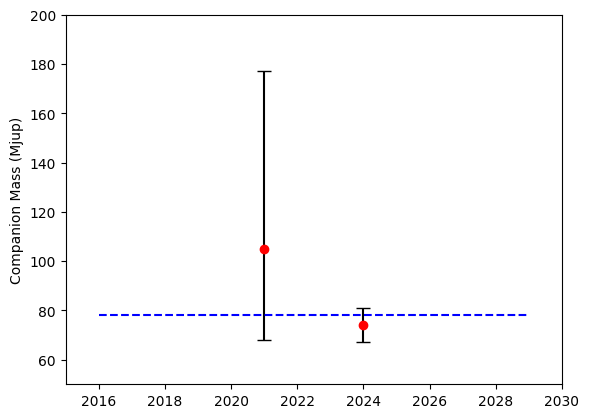

In [18]:
x = [2021, 2024]
y = [105.0, 73.9]
thresh = [78.0, 78.0]

y_min = [37, 6.9]
y_max = [72, 6.9]

plt.errorbar(x, y, yerr = [y_min, y_max], ls=' ', marker='o', color='red', capsize=5, capthick=1, ecolor='black')
plt.plot(list(np.arange(2016, 2030)), [78] * 14, color='blue', ls='--')
plt.ylabel('Companion Mass (Mjup)')
plt.ylim(50, 200)
plt.xlim(2015, 2030)

In [35]:
def backgroundNoise(band):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs

    output_prefix = f"../fmdata/FM_2023_{band}/fwhm=f"
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")

    img = data_hdu[0].data[0]

    ydat, xdat = np.indices(img.shape)
    distance_from_center = np.sqrt((ydat - int(ctrs[band][1]))**2 + (xdat - int(ctrs[band][0]))**2)

    radial_pixels = np.where(abs(distance_from_center - int(pixel_sep[band])) < 2)
    zipRP = list(zip(radial_pixels[0], radial_pixels[1]))

    bgNoise = []
    
    for i in range(0, len(zipRP), 115):
        if abs(zipRP[i][0] - planet_placement[band][0]) < 10 and abs(zipRP[i][1] - planet_placement[band][1]) < 10:
            continue

        miny, maxy, minx, maxx = zipRP[i][1] - 7, zipRP[i][1] + 8, zipRP[i][0] - 7, zipRP[i][0] + 8
        img_sq = img[miny:maxy, minx:maxx]

        # print(zipRP[i], img[zipRP[i][1], zipRP[i][0]])

        bgNoise.append(np.matrix.sum(np.matrix(makeGaussian(size=15, amplitude=abs(img[zipRP[i][1], zipRP[i][0]])/alphas[band][0], fwhm=fwhms[band]))))

    avgBgNoise = sum(bgNoise) / len(bgNoise)

    signalModel = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
    signal = np.matrix.sum(np.matrix(signalModel))
    
    return signal / time[band], avgBgNoise/time[band]
    

alphas = {
    '12_H': [2.141395, 0.0725038],
    '12_J': [1.7794925362274712, 0.1108811125757122],
    '12_Kshort': [1.1384276736180248, 0.07586519957858306],
    '02_H': [18.682818980108962, 1.022545050122007],
    '12_CH4short': [2.5061067868715603, 0.09169729565190132]
}
    
fwhms = {
    '02_H': 2.00 * 2.355,
    '12_Kshort': 1.99 * 2.355,
    '12_CH4short': 1.55 * 2.355,
    '12_J': 2.05 * 2.355
}

ctrs = {
    '02_H': (433.833 - 1, 613.833 - 1),
    '12_Kshort': (431 - 1, 618 - 1),
    '12_CH4short': (453 - 1, 599.4 - 1),
    '12_J': (436 - 1, 611.5 - 1)
}

pixel_sep = {
    '02_H': 191.88,
    '12_Kshort': 191.623,
    '12_CH4short': 190.659,
    '12_J': 191.578
}

planet_placement = {
    '02_H': (624 - 1, 589 - 1), 
    '12_Kshort': (621 - 1, 590 - 1),
    '12_CH4short': (573 - 1, 642 - 1),
    '12_J': (625.3 - 1, 585.6 - 1)
}

time = {
    '12_H': 7.9965 * 4,
    '12_J': 9.99671 * 3,
    '12_Kshort': 9.99671 * 3,
    '02_H': 10 * 3,
    '12_CH4short': 10 * 3
}

print('(alpha, alphaError)')
for band in fwhms:
    print(band, alphas[band])

print('\n(planetCounts, planetError)')
for band in fwhms:
    print(band, backgroundNoise(band))

print('\n(starCounts, starError)')
for band in fwhms:
    starData(band)

(alpha, alphaError)
02_H [18.682818980108962, 1.022545050122007]
12_Kshort [1.1384276736180248, 0.07586519957858306]
12_CH4short [2.5061067868715603, 0.09169729565190132]
12_J [1.7794925362274712, 0.1108811125757122]

(planetCounts, planetError)
02_H (np.float64(25.12896208631785), np.float64(3.1796283372914944))
12_Kshort (np.float64(24.88705675139387), np.float64(2.849673820720191))
12_CH4short (np.float64(15.097633623195065), np.float64(0.558874069323739))
12_J (np.float64(26.406164314665023), np.float64(1.8231736026989556))

(starCounts, starError)
0.014
02_H 91669145.58035715 10760613.069869723
0.01
12_Kshort 12459472.329341235 801679.0114502016
0.01
12_CH4short 9279212.679909239 252490.60292870214
0.01
12_J 8632044.576417789 798596.4655393591
